# Agent and standard notions of extensive form games

The purpose of this tutorial is to explain the notions of `MixedBehaviorProfile.agent_max_regret` and `MixedBehaviorProfile.agent_liap_value`, and the corresponding solvers `Gambit.nash.enumpure_agent_solve` and `Gambit.nash.liap_agent_solve`. These notions are only relevant for *extensive-form games*, and so `agent_max_regret` and 
`agent_liap_value` are only available for `MixedBehaviorProfile`s and not for `MixedStrategyProfile`s.

# Nash equilibria are profiles with maximum regret 0

For either a `MixedBehaviorProfile` and a `MixedStrategyProfile`, the profile is a Nash equilibrium if and only if its maximum regret is zero.
The profiles maximum regret is the maximum over the players of the individual player regrets.
A player's regret is 0 if they are playing a mixed (including pure) best response; otherwise it is positive and 
is the different between the best response payoff (achievable via a pure strategy) against the other players' and what the player actually gets as payoff in this profile.

Let's see an example taken from [Myerson (1991)](#references).

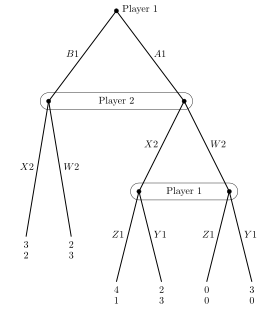

In [1]:
from draw_tree import draw_tree

import pygambit as gbt

g = gbt.read_efg("../../../contrib/games/myerson_fig_4_2.efg")
draw_tree(g)

Let's use `enumpure_solve` to find all pure Nash equilibria of this game.

In [2]:
pure_Nash_equilibria = gbt.nash.enumpure_solve(g).equilibria
print("Number of pure equilibria:", len(pure_Nash_equilibria))
pure_eq = pure_Nash_equilibria[0]
print("Max regret:", pure_eq.max_regret())

Number of pure equilibria: 1
Max regret: 0


We see that the game has only one pure Nash equilibrium and, its maximum regret is 0, which is what defines a Nash equilibrium.

In [3]:
eq = pure_Nash_equilibria[0]
for infoset, probs in eq.as_behavior().mixed_actions():
    print(infoset.player.label, "infoset:", infoset.number, "behavior probabilities:", probs)

Player 1 infoset: 0 behavior probabilities: [Rational(1, 1), Rational(0, 1)]
Player 1 infoset: 1 behavior probabilities: [Rational(0, 1), Rational(1, 1)]
Player 2 infoset: 0 behavior probabilities: [Rational(0, 1), Rational(1, 1)]


The `liap_value` which stands for "Liapunov value" is a related notion that sums the squared regrets of each pure strategy in the game. As with the maximum regret, the `liap_value` of a profile is 0 if and only if the profile is a Nash equilibrium, which we confirm now in our example:

In [4]:
print("Liap value:", pure_eq.liap_value())

Liap value: 0


As we have seen, both the maximum regret and Liapunov value of a profile are non-negative and zero if and only if the profile is a Nash equilibrium. When positive, one can think of both notions as describing how close one is to an equilibrium.

Based on this idea, the method `Gambit.nash.liap_solve` looks for *local* minima of the function from profiles to the Liapunov value. The set of Nash equilibria are exactly the *global* minima of this function, where the value is 0, but `liap_solve` may terminate at a non-global, local minimum, which is not a Nash equilibrium.

Let's use the method which requires us to specify a starting profile. The method works only with floating point profiles. We will create two profiles, one in floating point and one in rationals, using the former as the starting point for the method and the latter to check the maximum regret and Liapunov value of the profile exactly.

In [5]:
starting_profile_double = g.mixed_strategy_profile(data=[[0,1,0],[1,0]], rational=False)
starting_profile_rational = g.mixed_strategy_profile(data=[[0,1,0],[1,0]], rational=True)
print("Max regret of starting profile:", starting_profile_rational.max_regret())
print("Liapunov value of starting profile:", starting_profile_rational.liap_value())

Max regret of starting profile: 3
Liapunov value of starting profile: 14


It could be a useful exercise to make sure that you can compute these values of the maximum regret and Liapunov value. For that, the starting point would be computing the reduced strategic form. 

Returning to `liap_solve`, since the maximum regret and therefore Liapunov value are both positive, the starting profile is not a Nash equilibrium and we expect `liap_solve` to return a different profile, which will hopefully, but not necessarily by a Nash equilibrium, depending on whether the solver finding a global minimum, or non-global local minimum, or nothing at all.

In [6]:
candidate_eq = gbt.nash.liap_solve(start=starting_profile_double).equilibria[0]
print(candidate_eq)

[[4.2517925671604327e-07, 0.49999911111761514, 0.5000004637031282], [0.3333333517938241, 0.6666666482061759]]


In [7]:
print("Liap value:", candidate_eq.liap_value())
print("Max regret:", candidate_eq.max_regret())

Liap value: 4.43446520109796e-14
Max regret: 1.694170896904268e-07


In [8]:
candidate_eq_rat = g.mixed_strategy_profile(data=[[0,"1/2","1/2"],["1/3","2/3"]], rational=True)
print("Liap value:", candidate_eq_rat.liap_value())
print("Max regret:", candidate_eq_rat.max_regret())

Liap value: 0
Max regret: 0


Finally, before looking beyond Nash equilibria to "agent Nash equilibria", we will use Gambit's `enummixed_solve` to find all extreme mixed (including pure) Nash equilibria of this game.

In [9]:
all_extreme_Nash_equilibria = gbt.nash.enummixed_solve(g).equilibria
for eq in all_extreme_Nash_equilibria:
    print(eq)

[[Rational(0, 1), Rational(1, 1), Rational(0, 1)], [Rational(0, 1), Rational(1, 1)]]
[[Rational(1, 4), Rational(0, 1), Rational(3, 4)], [Rational(1, 2), Rational(1, 2)]]
[[Rational(0, 1), Rational(1, 2), Rational(1, 2)], [Rational(1, 3), Rational(2, 3)]]


The first of these is the pure equilibrium we found above with `enumpure_solve`. The last of these if the mixed equilibrium we just found with `liap_solve`. The middle of these is a new mixed equilibrium we haven't seen yet. Let's just confirm that it too, like the first and last, also have Liapunov value and maximum regret zero, as required for a Nash equilibrium:

In [10]:
print(all_extreme_Nash_equilibria[2])
print("Liap value:", all_extreme_Nash_equilibria[2].liap_value())
print("Max regret:", all_extreme_Nash_equilibria[2].max_regret())

[[Rational(0, 1), Rational(1, 2), Rational(1, 2)], [Rational(1, 3), Rational(2, 3)]]
Liap value: 0
Max regret: 0


# Agent maximum regret versus standard maximum regret

Now we can introduce the "agent" versions of both of the notions, maximum regret and the Liapunov value. The "agent" versions relate to what [Myerson (1991)](#references) called the "multi-agent representation" of an extensive form game, in which each information set is treated as an individual "agent". The "agent maximum regret" is then either 0 (if every information set has regret 0, i.e. `infoset_regret` 0), or it is largest of the information set regrets, which is then necessarily positive.

The maximum regret of a profile is at least at large as the agent maximum regret. 
In short, the reason it cannot be smaller is that all possible deviations of a given player -- even those that require changing behavior at multiple information sets -- are considered.
In particular, that includes deviations at a single information set, or at more than one.
On the other hand, the agent maximum regret only considers deviations at a single information set at a time, by considering each such information set as an "agent".

Thus, **if the maximum regret is 0, then we have a Nash equilibrium, and the agent maximum regret will be 0 too**.
However, **there are examples where a profile has agent maximum regret of 0 but positive maximum regret**, so the profile is 
not a Nash equilibrium.

There is also an analagous distinction between `agent_liap_value` and `liap_value`, where the `liap_value` is at least as large as the `agent_liap_value` and there are examples where the former is positive (so we do not have a Nash equilibrium) but the latter is 0 (so we have an "agent Nash equilibrium".

The game given above is such an example. It is taken from [Myerson (1991)](#references) figure 4.2. 

Gambit implements version of `enumpure_solve` and `liap_solve` called `enumpure_agent_solve` and `agent_liap_solve` that work only for the extensive form and use `agent_max_regret` and `agent_liap_value` respectively. 

In [11]:
pure_agent_equilibria = gbt.nash.enumpure_agent_solve(g).equilibria
print(len(pure_agent_equilibria))
for agent_eq in pure_agent_equilibria:
    print(agent_eq)

2
[[[Rational(1, 1), Rational(0, 1)], [Rational(0, 1), Rational(1, 1)]], [[Rational(0, 1), Rational(1, 1)]]]
[[[Rational(0, 1), Rational(1, 1)], [Rational(0, 1), Rational(1, 1)]], [[Rational(1, 1), Rational(0, 1)]]]


The first of the pure agent equilibria is the Nash equilibrium we found above, which we can check if we convert the agent equilibrium from a `MixedBehaviorProfile` to a `MixedStrategyProfile`:

In [12]:
pure_Nash_equilibria[0] == pure_agent_equilibria[0].as_strategy()

True

The second agent equilibrium is not a Nash equilibrium, which we can confirm by showing that it's `max_regret` and `liap_value` are both positive, while the agent versions of these are 0 (which is why this profile was returned by `enumpure_agent_solve`:

In [13]:
aeq = pure_agent_equilibria[1]
print("Max regret:", aeq.max_regret())
print("Liapunov value:", aeq.liap_value())
print("Agent max regret", aeq.agent_max_regret())
print("Agent Liapunov value:", aeq.agent_liap_value())

Max regret: 1
Liapunov value: 1
Agent max regret 0
Agent Liapunov value: 0


It is a useful exercise to make sure you can confirm that the pure profile `pure_agent_equilibria[1]` indeed has these values of agent and standard maximum regret and Liapunov value.

To conclude, we note that, for most use cases, the standard non-agent versions are probably what a user wants. The agent versions have applications in the area of "equilibrium refinements", in particular for "sequential equilibria"; for more details see Chapter 4, "Sequential Equilibria of Extensive-Form Games", in [Myerson (1991)](#references).

#### References

Roger Myerson (1991) "Game Theory: Analysis of Conflict." Harvard University Press. 